In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve
)

In [2]:
df = pd.read_csv('fake_or_real_news.csv')
df.head()

/var/folders/md/rqj13x553qn75v2xz2ykx9fw0000gn/T/ipykernel_71187/2905093077.py:1: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fake_or_real_news.csv')


,text,label,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,It's primary day in New York and front-runners...,REAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.describe()

,text,label,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138
count,6929,6755,318,241,179,133,91,65,55,38,...,1,1,1,1,1,1,1,1,1,1
unique,6644,437,315,241,179,133,91,65,55,38,...,1,1,1,1,1,1,1,1,1,1
top,"Killing Obama administration rules, dismantlin...",REAL,etc.,bold way,” Maureen Dowd writes. “Before he jumped into ...,Trump was seen as bombastic,vulgar,a bit of a buffoon and a cave man,but [also] ‘a cheeky brio.’ He was not regard...,not a predator … But he created another chara...,...,rather than acting out of a sober evaluation ...,but to me,more and more,the whole shooting match seems to come down t...,if one could discredit the idea of American e...,then it becomes much easier to have a serious...,a presidential candidate,a senator can stand behind the podium and mak...,it just seems that undertaking a serious crit...,REAL
freq,58,3161,3,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [4]:
df.isnull().sum()

text             866
label           1040
Unnamed: 2      7477
Unnamed: 3      7554
Unnamed: 4      7616
                ... 
Unnamed: 134    7794
Unnamed: 135    7794
Unnamed: 136    7794
Unnamed: 137    7794
Unnamed: 138    7794
Length: 139, dtype: int64

In [5]:
TEXT_COL = "text" if "text" in df.columns else next(
    (c for c in ["content", "article", "body"] if c in df.columns), None
)
LABEL_COL = "label" if "label" in df.columns else next(
    (c for c in ["target", "class", "category"] if c in df.columns), None
)

if TEXT_COL is None or LABEL_COL is None:
    raise ValueError(f"Could not identify text/label columns. Found: {df.columns.tolist()}")

In [6]:
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()
df[TEXT_COL] = df[TEXT_COL].astype(str).fillna("")
df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

In [7]:
labels_upper = df[LABEL_COL].str.upper()
if labels_upper.isin({"FAKE", "REAL"}).mean() > 0.8:
    df = df[labels_upper.isin({"FAKE", "REAL"})].copy()
    df[LABEL_COL] = df[LABEL_COL].str.upper().map({"FAKE": 1, "REAL": 0})
else:
    df[LABEL_COL], class_names = pd.factorize(df[LABEL_COL])

print("\nLabel distribution after cleaning:\n", df[LABEL_COL].value_counts())


Label distribution after cleaning:
 label
0    3161
1    3154
Name: count, dtype: int64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df[TEXT_COL], df[LABEL_COL],
    test_size=0.20, random_state=42, stratify=df[LABEL_COL]
)
print(f"\nTrain size: {len(X_train)} | Test size: {len(X_test)}")


Train size: 5052 | Test size: 1263


In [10]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("nb", MultinomialNB())  # alpha can be tuned later
])

In [11]:
pipe.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('nb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [12]:
y_pred  = pipe.predict(X_test)
acc     = accuracy_score(y_test, y_pred)
cm      = confusion_matrix(y_test, y_pred)

In [13]:
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


Accuracy: 0.8464

Classification Report:
               precision    recall  f1-score   support

           0      0.775     0.976     0.864       632
           1      0.968     0.716     0.823       631

    accuracy                          0.846      1263
   macro avg      0.872     0.846     0.844      1263
weighted avg      0.871     0.846     0.844      1263



<Figure size 640x480 with 0 Axes>

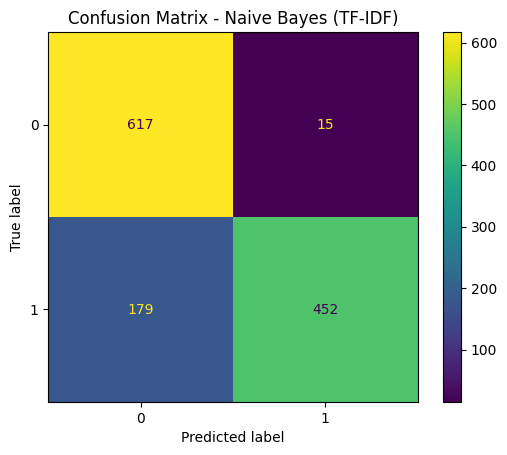

In [14]:
plt.figure()
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix - Naive Bayes (TF-IDF)")
plt.show()

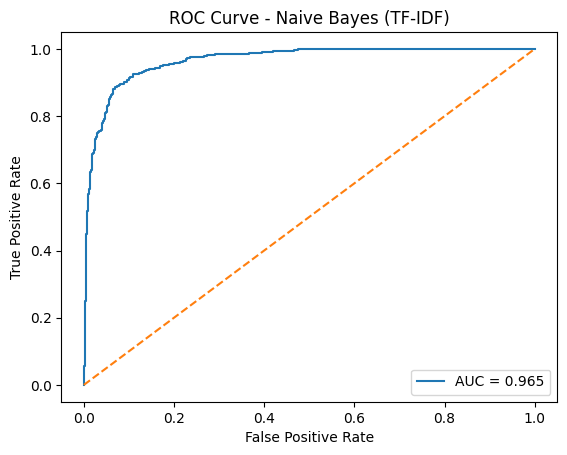

In [15]:
if len(np.unique(y_test)) == 2 and hasattr(pipe, "predict_proba"):
    y_proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Naive Bayes (TF-IDF)")
    plt.legend(loc="lower right")
    plt.show()

In [16]:
print("""
Summary of findings:
- Naive Bayes + TF-IDF delivers a solid baseline for Fake/Real classification.
- Check the confusion matrix to see which class is more often misclassified.
- ROC AUC (if binary) close to 1 means strong separability.
Suggested improvements:
- Add n-grams: TfidfVectorizer(ngram_range=(1,2)), tweak min_df/max_df.
- Tune smoothing: MultinomialNB(alpha=0.1, 0.5, 1.0, ...).
- Clean text further (URLs, punctuation, lowercasing, lemmatization/stemming).
""")


Summary of findings:
- Naive Bayes + TF-IDF delivers a solid baseline for Fake/Real classification.
- Check the confusion matrix to see which class is more often misclassified.
- ROC AUC (if binary) close to 1 means strong separability.
Suggested improvements:
- Add n-grams: TfidfVectorizer(ngram_range=(1,2)), tweak min_df/max_df.
- Tune smoothing: MultinomialNB(alpha=0.1, 0.5, 1.0, ...).
- Clean text further (URLs, punctuation, lowercasing, lemmatization/stemming).

